### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset de descripciones de empresas en linkedin: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

In [2]:
ls

sample_data/


In [7]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('companies.csv.zip', compression='zip')
df = df[['description']]

In [8]:
# función que toma solo las primeras 13 palabras de cada descripción
def first_13_words(text):
    if isinstance(text, str):  # Verifica si es una cadena de texto
        return ' '.join(text.split()[:13])
    return text

df['description'] = df['description'].apply(first_13_words)

In [9]:
df = df.iloc[0:1000]

In [10]:
df.head()

,description
0,"At IBM, we do more than work. We create. We cr..."
1,Every day millions of people feel the impact o...
2,Official LinkedIn of Hewlett Packard Enterpris...
3,We’re a cloud technology company that provides...
4,Accenture is a leading global professional ser...


In [12]:
# Concatenar los primeros 1000 elementos del DataFrame (suponiendo que la columna con los textos se llama 'documento')
article_text = '\n'.join(df['description'].head(1000))
article_text

'At IBM, we do more than work. We create. We create as technologists,\nEvery day millions of people feel the impact of our intelligent devices, advanced\nOfficial LinkedIn of Hewlett Packard Enterprise, the global edge-to-cloud company. Sharing our passion\nWe’re a cloud technology company that provides organizations around the world with computing\nAccenture is a leading global professional services company that helps the world’s leading\nEvery company has a mission. What\'s ours? To empower every person and every\nDeloitte drives progress. Our firms around the world help clients become leaders wherever\nSiemens AG (Berlin and Munich) is a leading technology company focused on industry,\nAt PwC, our purpose is to build trust in society and solve important\nWe understand that our customers want an easier, less complicated life. We’re using\nIntel’s mission is to shape the future of technology to help create a\nOur purpose To create connections that make the unimaginable possible. Our v

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [13]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [14]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [15]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [16]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

104

In [17]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [18]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [19]:
tokenized_text[:1000]

[97,
 73,
 68,
 60,
 13,
 29,
 92,
 68,
 47,
 14,
 68,
 58,
 75,
 68,
 69,
 75,
 80,
 14,
 68,
 73,
 91,
 62,
 93,
 68,
 47,
 75,
 80,
 99,
 59,
 68,
 87,
 14,
 68,
 11,
 80,
 14,
 62,
 73,
 14,
 59,
 68,
 87,
 14,
 68,
 11,
 80,
 14,
 62,
 73,
 14,
 68,
 62,
 6,
 68,
 73,
 14,
 11,
 91,
 93,
 75,
 67,
 75,
 4,
 2,
 6,
 73,
 6,
 92,
 98,
 40,
 94,
 14,
 80,
 90,
 68,
 58,
 62,
 90,
 68,
 69,
 2,
 67,
 67,
 2,
 75,
 93,
 6,
 68,
 75,
 84,
 68,
 35,
 14,
 75,
 35,
 67,
 14,
 68,
 84,
 14,
 14,
 67,
 68,
 73,
 91,
 14,
 68,
 2,
 69,
 35,
 62,
 11,
 73,
 68,
 75,
 84,
 68,
 75,
 26,
 80,
 68,
 2,
 93,
 73,
 14,
 67,
 67,
 2,
 4,
 14,
 93,
 73,
 68,
 58,
 14,
 94,
 2,
 11,
 14,
 6,
 92,
 68,
 62,
 58,
 94,
 62,
 93,
 11,
 14,
 58,
 98,
 3,
 84,
 84,
 2,
 11,
 2,
 62,
 67,
 68,
 8,
 2,
 93,
 99,
 14,
 58,
 60,
 93,
 68,
 75,
 84,
 68,
 78,
 14,
 47,
 67,
 14,
 73,
 73,
 68,
 51,
 62,
 11,
 99,
 62,
 80,
 58,
 68,
 40,
 93,
 73,
 14,
 80,
 35,
 80,
 2,
 6,
 14,
 92,
 68,
 73,
 91,
 14,
 68,
 

### Organizando y estructurando el dataset

In [20]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [21]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [22]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [23]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [24]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [25]:
X.shape

(76337, 100)

In [26]:
X[0,:10]

array([97, 73, 68, 60, 13, 29, 92, 68, 47, 14])

In [27]:
y[0,:10]

array([73, 68, 60, 13, 29, 92, 68, 47, 14, 68])

In [28]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [29]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [33]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 104)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 200)           │          61,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 104)           │          20,904 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,904 (319.94 KB)

 Trainable params: 81,904 (319.94 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [34]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [35]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.1011


 mean perplexity: 12.033841696906693 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 3.1000
Epoch 2/20
296/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.3096


 mean perplexity: 10.68979934846866 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2.3088
Epoch 3/20
298/299 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1017


 mean perplexity: 9.614065635819019 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2.1015
Epoch 4/20
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9635


 mean perplexity: 8.768220939775256 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.9632
Epoch 5/20
296/299 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8662


 mean perplexity: 8.708027949851227 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.8660
Epoch 6/20
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7951


 mean perplexity: 8.22502106002819 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.7949
Epoch 7/20
296/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7406


 mean perplexity: 8.161613231249461 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1.7405
Epoch 8/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7007


 mean perplexity: 8.116242744584943 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1.7006
Epoch 9/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6680


 mean perplexity: 8.085000974258344 

Saved new model!
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1.6680
Epoch 10/20
298/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6375
 mean perplexity: 8.388544897890833 

299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.6374
Epoch 11/20
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6176
 mean perplexity: 8.335157289454726 

299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 1.6175
Epoch 12/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5988
 mean perplexity: 8.332261477137813 

299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.5988
Epoch 13/20
296/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5835
 mean perplexity: 8.378926448196284 

299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.5834
Epoch 14/20
296/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5685
 mean perplexity: 8.208452116486555 

Stopping training...
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.5685


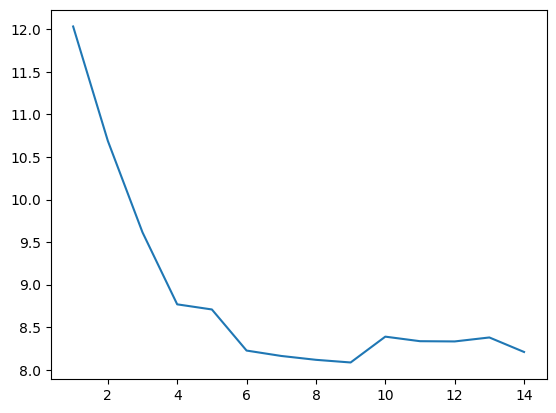

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [37]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')


### Predicción del próximo caracter

In [38]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.2 MB/s eta 0:00:00


In [39]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://499ca4680d960511d1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://499ca4680d960511d1.gradio.live


### Generación de secuencias

In [40]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [47]:
input_text='at ibm we d'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'at ibm we doversity of the world’s leadin'

###  Beam search y muestreo aleatorio

In [48]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [49]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [50]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="at ibm we d")

In [51]:
salidas[0]

array([62, 73, 68,  2, 95, 69, 68, 47, 14, 68, 58, 14, 67,  2, 94, 14, 80,
        6, 68, 73, 91, 14, 68, 47, 75, 80, 67, 58,  9,  6, 68])

In [52]:
# veamos las salidas
decode(salidas[0])

'at ibm we delivers the world’s '

# Conclusión

Para el mismo dataset se obtuvo un mejor comportamiento con el modelo que tokeniza los caracteres en vez de las palabras.